In [1]:
import numpy as np 
from pathlib import Path
from src import utils, db
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 12
fs_title = 14
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI
areas = ["V1", "medial", "lateral", "anterior"]
ctypes = ["Excitatory", "Inhibitory"]
corridor_length = 400
from IPython.display import clear_output

In [2]:
def dprime_cell(response, condition1, condition2, discrimination_region=(0,125), subpop=None):
    """
    Compute the d-prime for a single cell.
    """
    response = response[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    r1 = response[:, condition1]
    r2 = response[:, condition2]
    if subpop is not None:
        r1 = r1[subpop]
        r2 = r2[subpop]
    # collect means and stds
    mu1 = r1.mean(1)
    mu2 = r2.mean(1)
    std1 = r1.std(1) + np.finfo(np.float64).tiny
    std2 = r2.std(1) + np.finfo(np.float64).tiny
    #compute the train dprime
    dp = 2 * ((mu1 - mu2) / (std1 + std2))
    return dp

def select_neurons(m1, area: str, celltype:str, dprime = None, dptsh=95):
    ia = utils.get_region_idx(m1.iarea, area)
    assert celltype in ['exc', 'inh'], "celltype must be either 'exc' or 'inh'"
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool) if celltype == 'exc' else m1.isred[:,0].astype(bool)
    if dprime is None:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=dptsh) #tresh based on the area
    else:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dprime[ia*selected_type], tsh=dptsh)
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    return area_prefer_r, area_prefer_nr, selected_type, ia



def plot_cds(day_response, ttype, area, ctype, ax, references=True):
    from scipy.stats import sem
    """ 
    Plot the mean and SEM of the coding direction for a given trial type, area, and cell type.
    Parameters
    ----------
    day_response : np.ndarray
        The coding direction data for the day. Shape: (n_mice, n_trial_types, n_areas, n_cell_types, corridor_length)
    ttype : int
        The trial type index (0: rewarded, 1: non-rewarded, 2: rewarded test, 3: non-rewarded test).
    area : int
        The area index (0: V1, 1: medial, 2: lateral, 3: anterior).
    ctype : int
        The cell type index (0: excitatory, 1: inhibitory).
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    nmice, ntrial_types, nareas, ncelltypes, corridor_length = day_response.shape
    mean_response = np.mean(day_response, axis=0)
    sem_response = sem(day_response, axis=0)
    ax.plot(mean_response[ttype, area, ctype], color=trial_type_palette[ttype], linewidth=2)
    ax.fill_between(np.arange(corridor_length), mean_response[ttype, area, ctype] - sem_response[ttype, area, ctype],
                                mean_response[ttype, area, ctype] + sem_response[ttype, area, ctype],
                                color=trial_type_palette[ttype], alpha=0.2)
    if references:
        ax.axvline(x=150, color='gray', linestyle='--', alpha=0.2)
        ax.axvline(x=300, color='gray', linestyle='--', alpha=0.2)

In [3]:
correct_incorrect = np.load(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\correct_incorrect_cds.npy"))  # mice, ttype, areas, cell types, correct/incorrect, positions
correct = correct_incorrect[:, :, :, :, 0, :]
incorrect = correct_incorrect[:, :, :, :, 1, :]

In [5]:
correct.shape

(4, 4, 4, 2, 400)

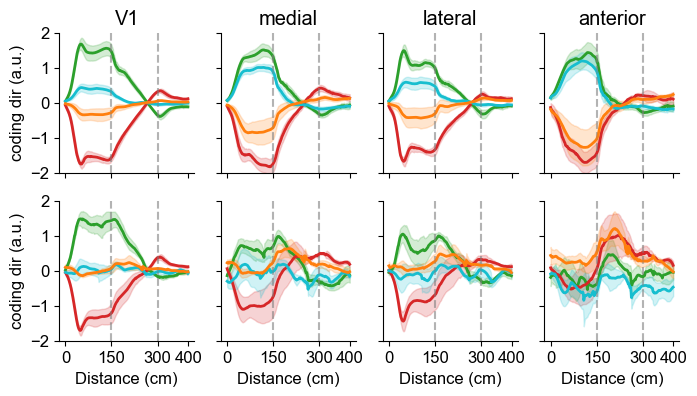

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)
for iday, day_response in enumerate([correct, incorrect]):
    ax[iday,-1].set_xticks([0, 150, 300, 400])
    ax[iday,0].set_ylabel('coding dir (a.u.)')
    for ttype in range(4):
        for a, area in enumerate(areas):
            ax[1,a].set_xlabel('Distance (cm)')
            plot_cds(day_response, ttype, a, 0, ax[iday,a], references=True)
            ax[iday,a].set_ylim(-2,2)
            if iday == 0:
                ax[iday,a].set_title(f"{areas[a]}", loc='center')
                #rotate xticks

In [6]:
def attention_effect(correct, incorrect, area, ctype, pos=(0,100)):
    """
    Calculate the attention effect for a given area and cell type.
    Parameters
    ----------
    correct : np.ndarray
        The coding direction data for correct trials.
    incorrect : np.ndarray
        The coding direction data for incorrect trials.
    area : int
        The area index (0: V1, 1: medial, 2: lateral, 3: anterior).
    ctype : int
        The cell type index (0: excitatory, 1: inhibitory).
    Returns
    -------
    np.ndarray
        The attention effect for the specified area and cell type.
    """
    correct = correct[:, :, area, ctype, pos[0]:pos[1]].mean(axis=-1)
    incorrect = incorrect[:, :, area, ctype, pos[0]:pos[1]].mean(axis=-1)
    incorrect_sep = incorrect[:,0] - incorrect[:,1]
    correct_sep = correct[:,0] - correct[:,1]
    attention_eff = 1 - (np.abs(incorrect_sep) / np.abs(correct_sep))
    return attention_eff


def prot_di(correct, incorrect, area, ctype, pos=(0,100)):
    """
    Calculate the attention effect for a given area and cell type.
    Parameters
    ----------
    correct : np.ndarray
        The coding direction data for correct trials.
    incorrect : np.ndarray
        The coding direction data for incorrect trials.
    area : int
        The area index (0: V1, 1: medial, 2: lateral, 3: anterior).
    ctype : int
        The cell type index (0: excitatory, 1: inhibitory).
    Returns
    -------
    np.ndarray
        The attention effect for the specified area and cell type.
    """
    correct = correct[:, :, area, ctype, pos[0]:pos[1]].mean(axis=-1)
    incorrect = incorrect[:, :, area, ctype, pos[0]:pos[1]].mean(axis=-1)
    incorrect_sep = incorrect[:,0] - incorrect[:,1]
    correct_sep = correct[:,0] - correct[:,1]
    return correct_sep, incorrect_sep

def rest_di(correct, incorrect, area, ctype, pos=(0,100)):
    """
    Calculate the attention effect for a given area and cell type.
    Parameters
    ----------
    correct : np.ndarray
        The coding direction data for correct trials.
    incorrect : np.ndarray
        The coding direction data for incorrect trials.
    area : int
        The area index (0: V1, 1: medial, 2: lateral, 3: anterior).
    ctype : int
        The cell type index (0: excitatory, 1: inhibitory).
    Returns
    -------
    np.ndarray
        The attention effect for the specified area and cell type.
    """
    correct = correct[:, :, area, ctype, pos[0]:pos[1]].mean(axis=-1)
    incorrect = incorrect[:, :, area, ctype, pos[0]:pos[1]].mean(axis=-1)
    incorrect_sep = incorrect[:,2] - incorrect[:,3]
    correct_sep = correct[:,2] - correct[:,3]
    return correct_sep, incorrect_sep


In [17]:
correct_sep, incorrect_sep = prot_di(correct, incorrect, area, 0, pos=(0,100))

In [18]:
incorrect_sep/correct_sep

array([-0.05445396, -0.41034671,  1.1313141 ,  0.2063177 ])

In [127]:
incorrect_sep

array([-2.88855826, -1.99053423,  0.64651472, -1.34831246])

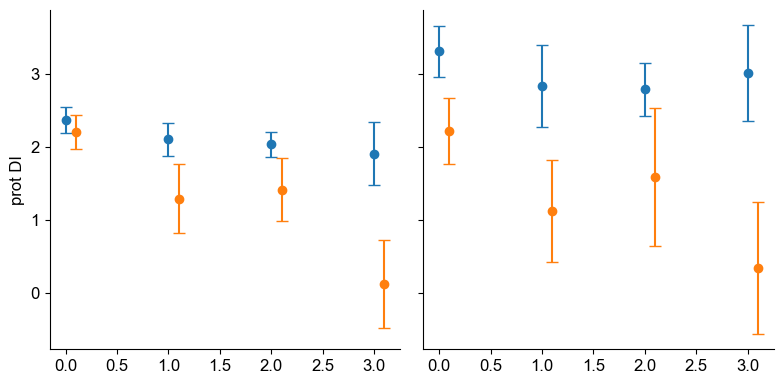

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
cell_types = ['Excitatory', 'Inhibitory']
positions = (0, 100)
from scipy.stats import sem
for ctype in range(2):
    for area in range(4):
        correct_sep, incorrect_sep = prot_di(correct, incorrect, area, ctype, pos=positions)
        for iff, eff in enumerate([correct_sep, incorrect_sep]):
            mean = eff.mean()
            sems = sem(eff)
            axes[ctype].errorbar(area+(iff*.1), mean, yerr=sems, fmt='o', capsize=4, color=['#1f77b4', '#ff7f0e'][iff])
            #axes[ctype].set_ylim(-.2, 1)
            axes[ctype].set_ylabel('prot DI' if ctype == 0 else "")
plt.tight_layout()
plt.show()

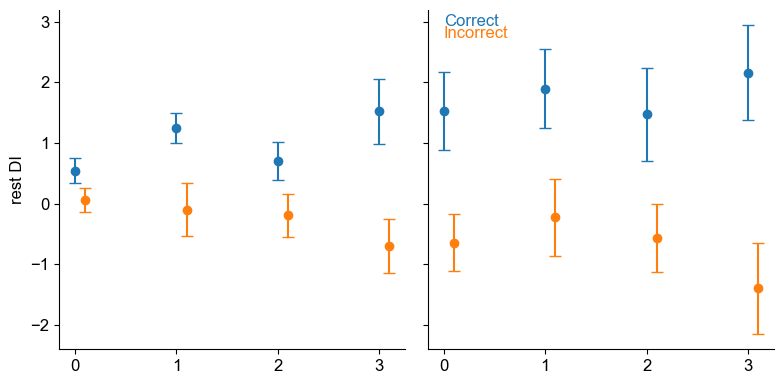

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
cell_types = ['Excitatory', 'Inhibitory']
positions = (0, 100)
labels = ['correct', 'incorrect']
from scipy.stats import sem
for ctype in range(2):
    for area in range(4):
        correct_sep, incorrect_sep = rest_di(correct, incorrect, area, ctype, pos=positions)
        for iff, eff in enumerate([correct_sep, incorrect_sep]):
            mean = eff.mean()
            sems = sem(eff)
            axes[ctype].errorbar(area+(iff*.1), mean, yerr=sems, fmt='o', capsize=4, color=['#1f77b4', '#ff7f0e'][iff])
            #axes[ctype].set_ylim(-.2, 1)
            axes[ctype].set_ylabel('rest DI' if ctype == 0 else "")
plt.text(0, 3, 'Correct', ha='left', va='center', color='#1f77b4')
plt.text(0, 2.8, 'Incorrect', ha='left', va='center', color='#ff7f0e')
plt.tight_layout()
plt.show()

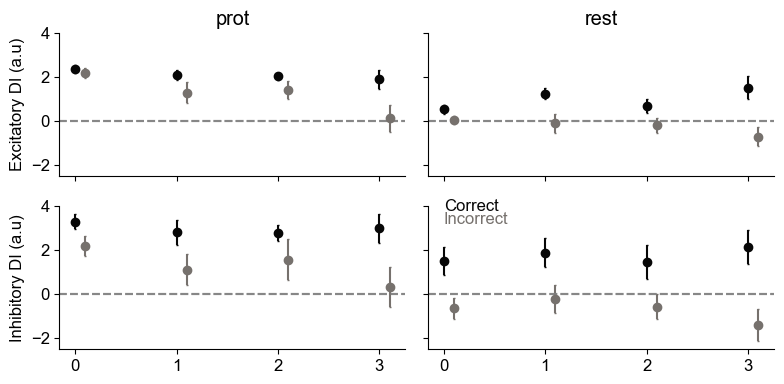

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharey=True, sharex=True)
cell_types = ['Excitatory', 'Inhibitory']
positions = (0, 100)
labels = ['correct', 'incorrect']
from scipy.stats import sem
for ctype in range(2):
    for area in range(4):
        correct_sep_pr, incorrect_sep_pr = prot_di(correct, incorrect, area, ctype, pos=positions)
        prot_sep = (correct_sep_pr, incorrect_sep_pr)
        correct_sep_rest, incorrect_sep_rest = rest_di(correct, incorrect, area, ctype, pos=positions)
        test_sep = (correct_sep_rest, incorrect_sep_rest)
        for iff, eff in enumerate([prot_sep, test_sep]):
            c_eff = eff[0].mean()
            c_sem_eff = sem(eff[0])
            i_eff = eff[1].mean()
            i_sem_eff = sem(eff[1])
            axes[ctype, iff].errorbar(area, c_eff, yerr=c_sem_eff, fmt='o', capsize=1, color="#070707")
            axes[ctype, iff].errorbar(area+.1, i_eff, yerr=i_sem_eff, fmt='o', capsize=1, color= "#76716d")
            axes[ctype, iff].set_ylim(-2.5, 4)
            axes[0, iff].set_title(f"{['prot', 'rest'][iff]}", loc='center')
            axes[ctype, iff].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            axes[ctype, 0].set_ylabel(f'{cell_types[ctype]} DI (a.u)')


            #axes[ctype].set_ylim(-.2, 1)
plt.text(0, 4, 'Correct', ha='left', va='center', color="#070707")
plt.text(0, 3.4, 'Incorrect', ha='left', va='center', color="#76716d")
plt.tight_layout()
plt.show()

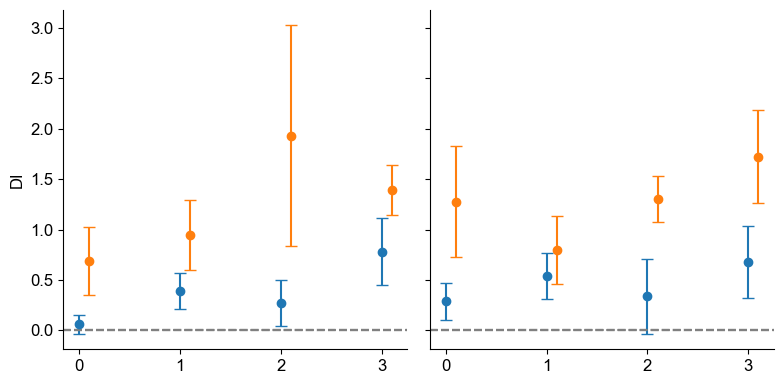

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
cell_types = ['Excitatory', 'Inhibitory']
positions = (0, 100)
from scipy.stats import sem
for ctype in range(2):
    for area in range(4):
        correct_sep, incorrect_sep = prot_di(correct, incorrect, area, ctype, pos=positions)
        prot_eff = 1-(incorrect_sep / correct_sep)
        correct_sep, incorrect_sep = rest_di(correct, incorrect, area, ctype, pos=positions)
        rest_eff = 1-(incorrect_sep / correct_sep)
        for iff, eff in enumerate([prot_eff, rest_eff]):
            mean = eff.mean()
            sems = sem(eff)
            axes[ctype].errorbar(area+(iff*.1), mean, yerr=sems, fmt='o', capsize=4, color=['#1f77b4', '#ff7f0e'][iff])
            #axes[ctype].set_ylim(-.2, 1)
            axes[ctype].set_ylabel('DI' if ctype == 0 else "")
            axes[ctype].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [39]:
def compute_gi(avgs_coding_dirs, pos):
    """
    Compute the GI for each cell type and area.
    GI = |cyan - orange| / |green - red|

    avgs_coding_dirs: array of shape (mice, ttype, area, cell type, positions)
    """
    gis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    dis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    gen = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    avgs_coding_dirs = avgs_coding_dirs[:,:,:,:,:pos].mean(-1) #mouse, ttype, area, cell type, positions
    for area in range(4):
        for cell_type in range(2):
            gen[:, area, cell_type] = avgs_coding_dirs[:,2,area,cell_type] - avgs_coding_dirs[:,3,area,cell_type]
            dis[:, area, cell_type] = avgs_coding_dirs[:,0,area,cell_type] - avgs_coding_dirs[:,1,area,cell_type]
            for m in range(avgs_coding_dirs.shape[0]):
                if (dis[m, area, cell_type] < 0) and (gen[m, area, cell_type] < 0):
                    gis[m, area, cell_type] = np.abs(gen[m, area, cell_type]) / np.abs(dis[m, area, cell_type]) * -1
                else:
                    gis[m, area, cell_type] = gen[m, area, cell_type] / dis[m, area, cell_type]
    return gis, dis, gen

def significance(pval):
    if  pval >= .05:
        sig = ''
    elif (pval < .05) and (pval >= .01):
        sig = '*'
    elif (pval < .01) and (pval >= .001):
        sig = '**'
    elif (pval < .001) and (pval >= .0001):
        sig = '***'
    else:
        sig = '****'
    return sig

def plot_gi_comparison(gis_sess, n_sess, labels, ax):
    """
    Plot the GI comparison between the first and last training sessions.
    Parameters
    ----------
    gis_sess : np.ndarray
        The GI data for the first and last training sessions. Shape: (sess*day, areas, ctypes)
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    from scipy.stats import ttest_rel, sem
    for a in range(4):
        for ctp in range(2):
            day_one_r = gis_sess[:n_sess, a, ctp]
            day_two_r = gis_sess[n_sess:, a, ctp]
            mean_day_one = np.mean(day_one_r, axis=0)
            mean_day_two = np.mean(day_two_r, axis=0)
            sem_day_one = sem(day_one_r, axis=0)
            sem_day_two = sem(day_two_r, axis=0)
            ax[ctp].scatter(a-.1, mean_day_one, color='gray', alpha=1, s=20)
            ax[ctp].scatter(a+.1, mean_day_two, color='k', alpha=1, s=20)
            ax[ctp].errorbar(a-.1, mean_day_one, yerr=sem_day_one, color='gray', alpha=1)
            ax[ctp].errorbar(a+.1, mean_day_two, yerr=sem_day_two, color='k', alpha=1)
            ax[ctp].set_xticks(np.arange(4), ['V1', 'medial', 'lateral', 'anterior'])
            
            ax[ctp].axhline(y=0, color='gray', linestyle='--', alpha=0.2)
            if ctp == 0:
                ax[ctp].set_ylabel('Invariance Index $(a.u.)$')
                #ax[ctp].set_yticks([-1,-.5, 0,.5, 1])
                ax[ctp].set_title("excitatory")
            else:
                ax[ctp].set_title("inhibitory")
            t, p = ttest_rel(day_two_r, day_one_r, alternative='greater')
            p_t = significance(p)
            ax[ctp].text(a, 1, p_t, ha='center', va='center', color='k', fontsize=20, transform=ax[ctp].transData)

            # connect lines between every sample point and each day
            #for m in range(4):
            #    ax[ctp].plot([a-.1, a+.1], [day_one_r[m], day_two_r[m]], color='k', linewidth=.5, alpha=0.4)

    ax[-1].text(1.1, .85, labels[0], ha='left', color='gray', transform=ax[-1].transAxes)
    ax[-1].text(1.1, .75, labels[1], ha='left', color='k',transform=ax[-1].transAxes)
    plt.tight_layout()

In [106]:
gis_correct, dis_first, gen_first = compute_gi(correct, 100)
gis_incorrect, dis_last_m, gen_last_m = compute_gi(incorrect, 100)

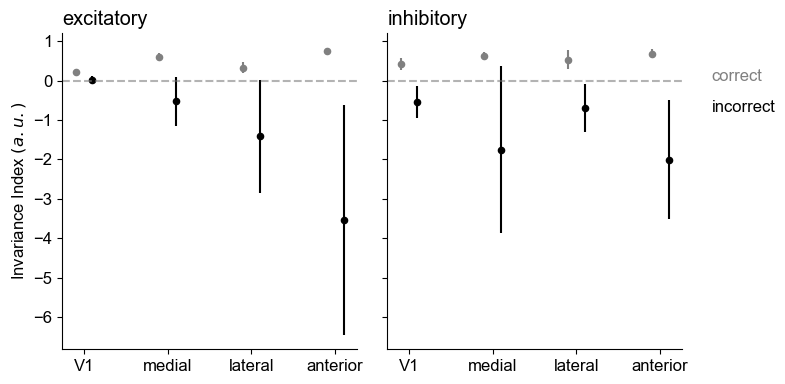

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
gis_sess = np.vstack((gis_correct, gis_incorrect))
n_sess = 4
labels = ['correct', 'incorrect']
plot_gi_comparison(gis_sess, n_sess, labels, ax)

In [110]:
dbase = db.get_sessions()
all_rew_after = dbase.query("session == 'all rewarded after'")
all_rew_after

,mname,datexp,blk,session
3,VG11,2024_11_01,2,all rewarded after
7,VG11,2024_11_15,2,all rewarded after
11,VG14,2024_11_23,2,all rewarded after
15,VG15,2024_11_01,3,all rewarded after


In [111]:
mice = []
for i, row in all_rew_after.iterrows():
    name, date, blk = row['mname'], row["datexp"], row["blk"]
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    mice.append(m)
    clear_output(wait=True)
print("all rewarded after loaded")

all rewarded after loaded


In [112]:
non_matched_cds = np.empty((len(mice), 4, len(areas), len(ctypes), corridor_length)) # mice, ttype, areas, cell types, positions
main_dir = Path(f"../data/notz/overall")
for im, m in enumerate(mice):
    protA = m.trial_dict["rewarded"][1::2]
    protB = m.trial_dict["non rewarded"][1::2]
    restA = m.trial_dict["rewarded test"]
    restB =  m.trial_dict["non rewarded test"]
    ## Dprime selection trials
    interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
    dp = dprime_cell(interp_spks, m.trial_dict["rewarded"][::2], m.trial_dict["non rewarded"][::2], discrimination_region=(0,100))
    nonmatched_dict = {"rewarded": protA, "non rewarded": protB, "rewarded test": restA, "non rewarded test": restB}
    for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
        for ct, c_type in enumerate(["exc", "inh"]):
            a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type, dprime=dp)
            cd = interp_spks[a_prefer].mean(0) - interp_spks[b_prefer].mean(0)
            for it, trials in enumerate(nonmatched_dict.values()):
                non_matched_cds[im, it, ia, ct] = cd[trials,:].mean(0)
np.save(main_dir/"cod_dirs_0_100_allrewafter.npy", non_matched_cds)

In [34]:
main_dir = Path(f"../data/notz/overall")
all_rew_after_cds = np.load(main_dir/"cod_dirs_0_100_allrewafter.npy")

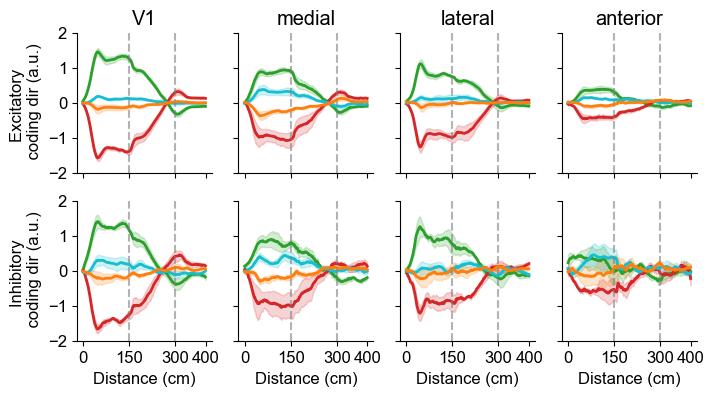

In [35]:
fig, ax = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)
for ttype in range(4):
    for a, area in enumerate(areas):
        for ic in range(2):
            ax[ic,a].set_xticks([0, 150, 300, 400])
            ax[ic,0].set_ylabel(f'{cell_types[ic]} \n coding dir (a.u.)')
            ax[1,a].set_xlabel('Distance (cm)')
            plot_cds(all_rew_after_cds, ttype, a, ic, ax[ic,a], references=True)
            ax[ic,a].set_ylim(-2,2)
            if ic == 0:
                ax[ic,a].set_title(f"{areas[a]}", loc='center')

In [50]:
def plot_gi_comparison_wcontrol(first_gi, second_gi, control_gi, ax):
    """
    Plot the GI comparison between the first and last training sessions.
    Parameters
    ----------
    gis_sess : np.ndarray
        The GI data for the first and last training sessions. Shape: (sess*day, areas, ctypes)
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    from scipy.stats import ttest_rel, sem
    colors = ["#b1afcf",'#756bb1',"#9691c7"]
    offset = [-0.1, 0.1, 0.3] # offset for the first, second and control GI
    labels = ['first day', 'last day (behavior matched)', 'last day (all trials)']
    for i_gi, gi in enumerate([first_gi, second_gi, control_gi]):
        for a in range(4):
            for ctp in range(2):
                mean = np.mean(gi[:, a, ctp], axis=0)
                sem_ = sem(gi[:, a, ctp], axis=0)
                ax[ctp].scatter(a+offset[i_gi], mean, color=colors[i_gi], alpha=1, s=20)
                ax[ctp].errorbar(a+offset[i_gi], mean, yerr=sem_, color=colors[i_gi], alpha=1)
                ax[ctp].set_xticks(np.arange(4), ['V1', 'medial', 'lateral', 'anterior'])
                ax[ctp].axhline(y=0, color='gray', linestyle='--', alpha=0.2)
                if ctp == 0:
                    ax[ctp].set_ylabel('Invariance Index $(a.u.)$')
                    ax[ctp].set_yticks([0,.25,.5,.75, 1, 1.25])
    ax[0].text(0.05, .12, "first training day", ha='left', color=colors[0], transform=ax[0].transAxes, fontsize=10)
    ax[0].text(0.05, .07, "last training day (matched)", ha='left', color=colors[1],transform=ax[0].transAxes, fontsize=10)
    ax[0].text(0.05, .02, "all rewarded day", ha='left', color=colors[2], transform=ax[0].transAxes, fontsize=10)

    for a in range(4):
        for ctp in range(2):
            day_one_r = first_gi[:, a, ctp]
            day_two_r = second_gi[:, a, ctp]
            control_r = control_gi[:, a, ctp]
            t, p = ttest_rel(day_two_r, day_one_r, alternative='greater')
            p_t = significance(p)
            if p<.05:
                ax[ctp].text(a, 1, p_t, ha='center', va='center', color='k', fontsize=15, transform=ax[ctp].transData)
                # a line between one category and the other
                from matplotlib.lines import Line2D
                line = Line2D([a-.1, a+.1], [1, 1], color='k', linewidth=1, alpha=1)
                ax[ctp].add_line(line)
            t, p = ttest_rel(control_r, day_one_r, alternative='greater')
            p_t = significance(p)
            if p<.05:
                ax[ctp].text(a+.1, 1.15, p_t, ha='center', va='center', color='k', fontsize=15, transform=ax[ctp].transData)
                # a line between one category and the other
                from matplotlib.lines import Line2D
                line = Line2D([a-.1, a+.3], [1.15, 1.15], color='k', linewidth=1, alpha=1)
                ax[ctp].add_line(line)
            for m in range(4):
                ax[ctp].plot([a-.1, a+.1], [day_one_r[m], day_two_r[m]], color='k', linewidth=.5, alpha=0.4)

In [51]:
first_day_cds = np.load(main_dir/"cod_dirs_0_100_fristtraining.npy")
last_day_matched_cds = np.load(main_dir/"matchbehav"/"cod_dirs_0_100_lasttraining_matched.npy")

In [ ]:
gis_first,_,_ = compute_gi(first_day_cds, 100)
gis_last,_,_ = compute_gi(last_day_matched_cds, 100)
gis_allrew,_,_ = compute_gi(all_rew_after_cds, 100)

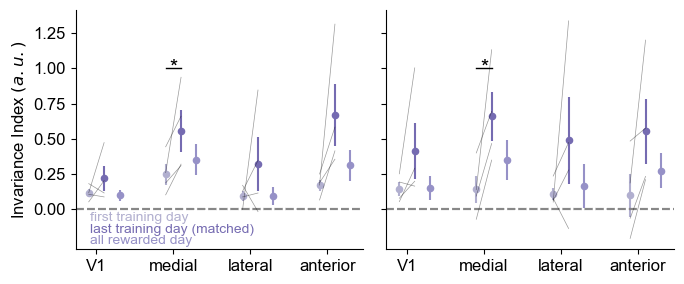

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), sharex=True, sharey=True)
plot_gi_comparison_wcontrol(gis_first, gis_last,  gis_allrew, ax)
plt.tight_layout()

In [168]:
def show_image(ax, img_path):
    ax.imshow(plt.imread(img_path))
    ax.axis('off')

In [151]:
def plot_gi_comparison_wcontrol2(first_gi, second_gi, control_gi, ax):
    """
    Plot the GI comparison between the first and last training sessions.
    Parameters
    ----------
    gis_sess : np.ndarray
        The GI data for the first and last training sessions. Shape: (sess*day, areas, ctypes)
    ax : matplotlib.axes.Axes
        The axes on which to plot the data.
    """
    from scipy.stats import ttest_rel, sem
    colors = ["#b1afcf",'#756bb1',"#9691c7"]
    offset = [-0.1, 0.1, 0.3] # offset for the first, second and control GI
    for i_gi, gi in enumerate([first_gi, second_gi, control_gi]):
        for a in range(4):
            for ctp in [0]:
                mean = np.mean(gi[:, a, ctp], axis=0)
                sem_ = sem(gi[:, a, ctp], axis=0)
                ax.scatter(a+offset[i_gi], mean, color=colors[i_gi], alpha=1, s=20)
                ax.errorbar(a+offset[i_gi], mean, yerr=sem_, color=colors[i_gi], alpha=1)
                ax.set_xticks(np.arange(4), ['V1', 'medial', 'lateral', 'anterior'])
                ax.axhline(y=0, color='gray', linestyle='--', alpha=0.2)
                if ctp == 0:
                    ax.set_ylabel('Invariance Index $(a.u.)$')
                    ax.set_yticks([0,.25,.5,.75, 1, 1.25])
    ax.text(0.05, .92, "first training day", ha='left', color=colors[0], transform=ax.transAxes, fontsize=10)
    ax.text(0.05, .87, "last training day (matched)", ha='left', color=colors[1],transform=ax.transAxes, fontsize=10)
    ax.text(0.05, .82, "all rewarded day", ha='left', color=colors[2], transform=ax.transAxes, fontsize=10)

    for a in range(4):
        for ctp in [0]:
            day_one_r = first_gi[:, a, ctp]
            day_two_r = second_gi[:, a, ctp]
            control_r = control_gi[:, a, ctp]
            t, p = ttest_rel(day_two_r, day_one_r, alternative='greater')
            p_t = significance(p)
            if p<.05:
                ax.text(a, 1, p_t, ha='center', va='center', color='k', fontsize=15, transform=ax.transData)
                # a line between one category and the other
                from matplotlib.lines import Line2D
                line = Line2D([a-.1, a+.1], [1, 1], color='k', linewidth=1, alpha=1)
                ax.add_line(line)
            t, p = ttest_rel(control_r, day_one_r, alternative='greater')
            p_t = significance(p)
            if p<.05:
                ax.text(a+.1, 1.15, p_t, ha='center', va='center', color='k', fontsize=15, transform=ax.transData)
                # a line between one category and the other
                from matplotlib.lines import Line2D
                line = Line2D([a-.1, a+.3], [1.15, 1.15], color='k', linewidth=1, alpha=1)
                ax.add_line(line)
            for m in range(4):
                ax.plot([a-.1, a+.1], [day_one_r[m], day_two_r[m]], color='k', linewidth=.5, alpha=0.4)

In [171]:
def move_axis(ax, hdx=0, vdx=0, widthdx=1, heightdx=1):
    poss = ax.get_position().bounds
    new_left = poss[0] + hdx
    new_bottom = poss[1] + vdx
    new_width = poss[2] * widthdx
    new_height = poss[3] * heightdx
    ax.set_position([new_left, new_bottom, new_width, new_height])

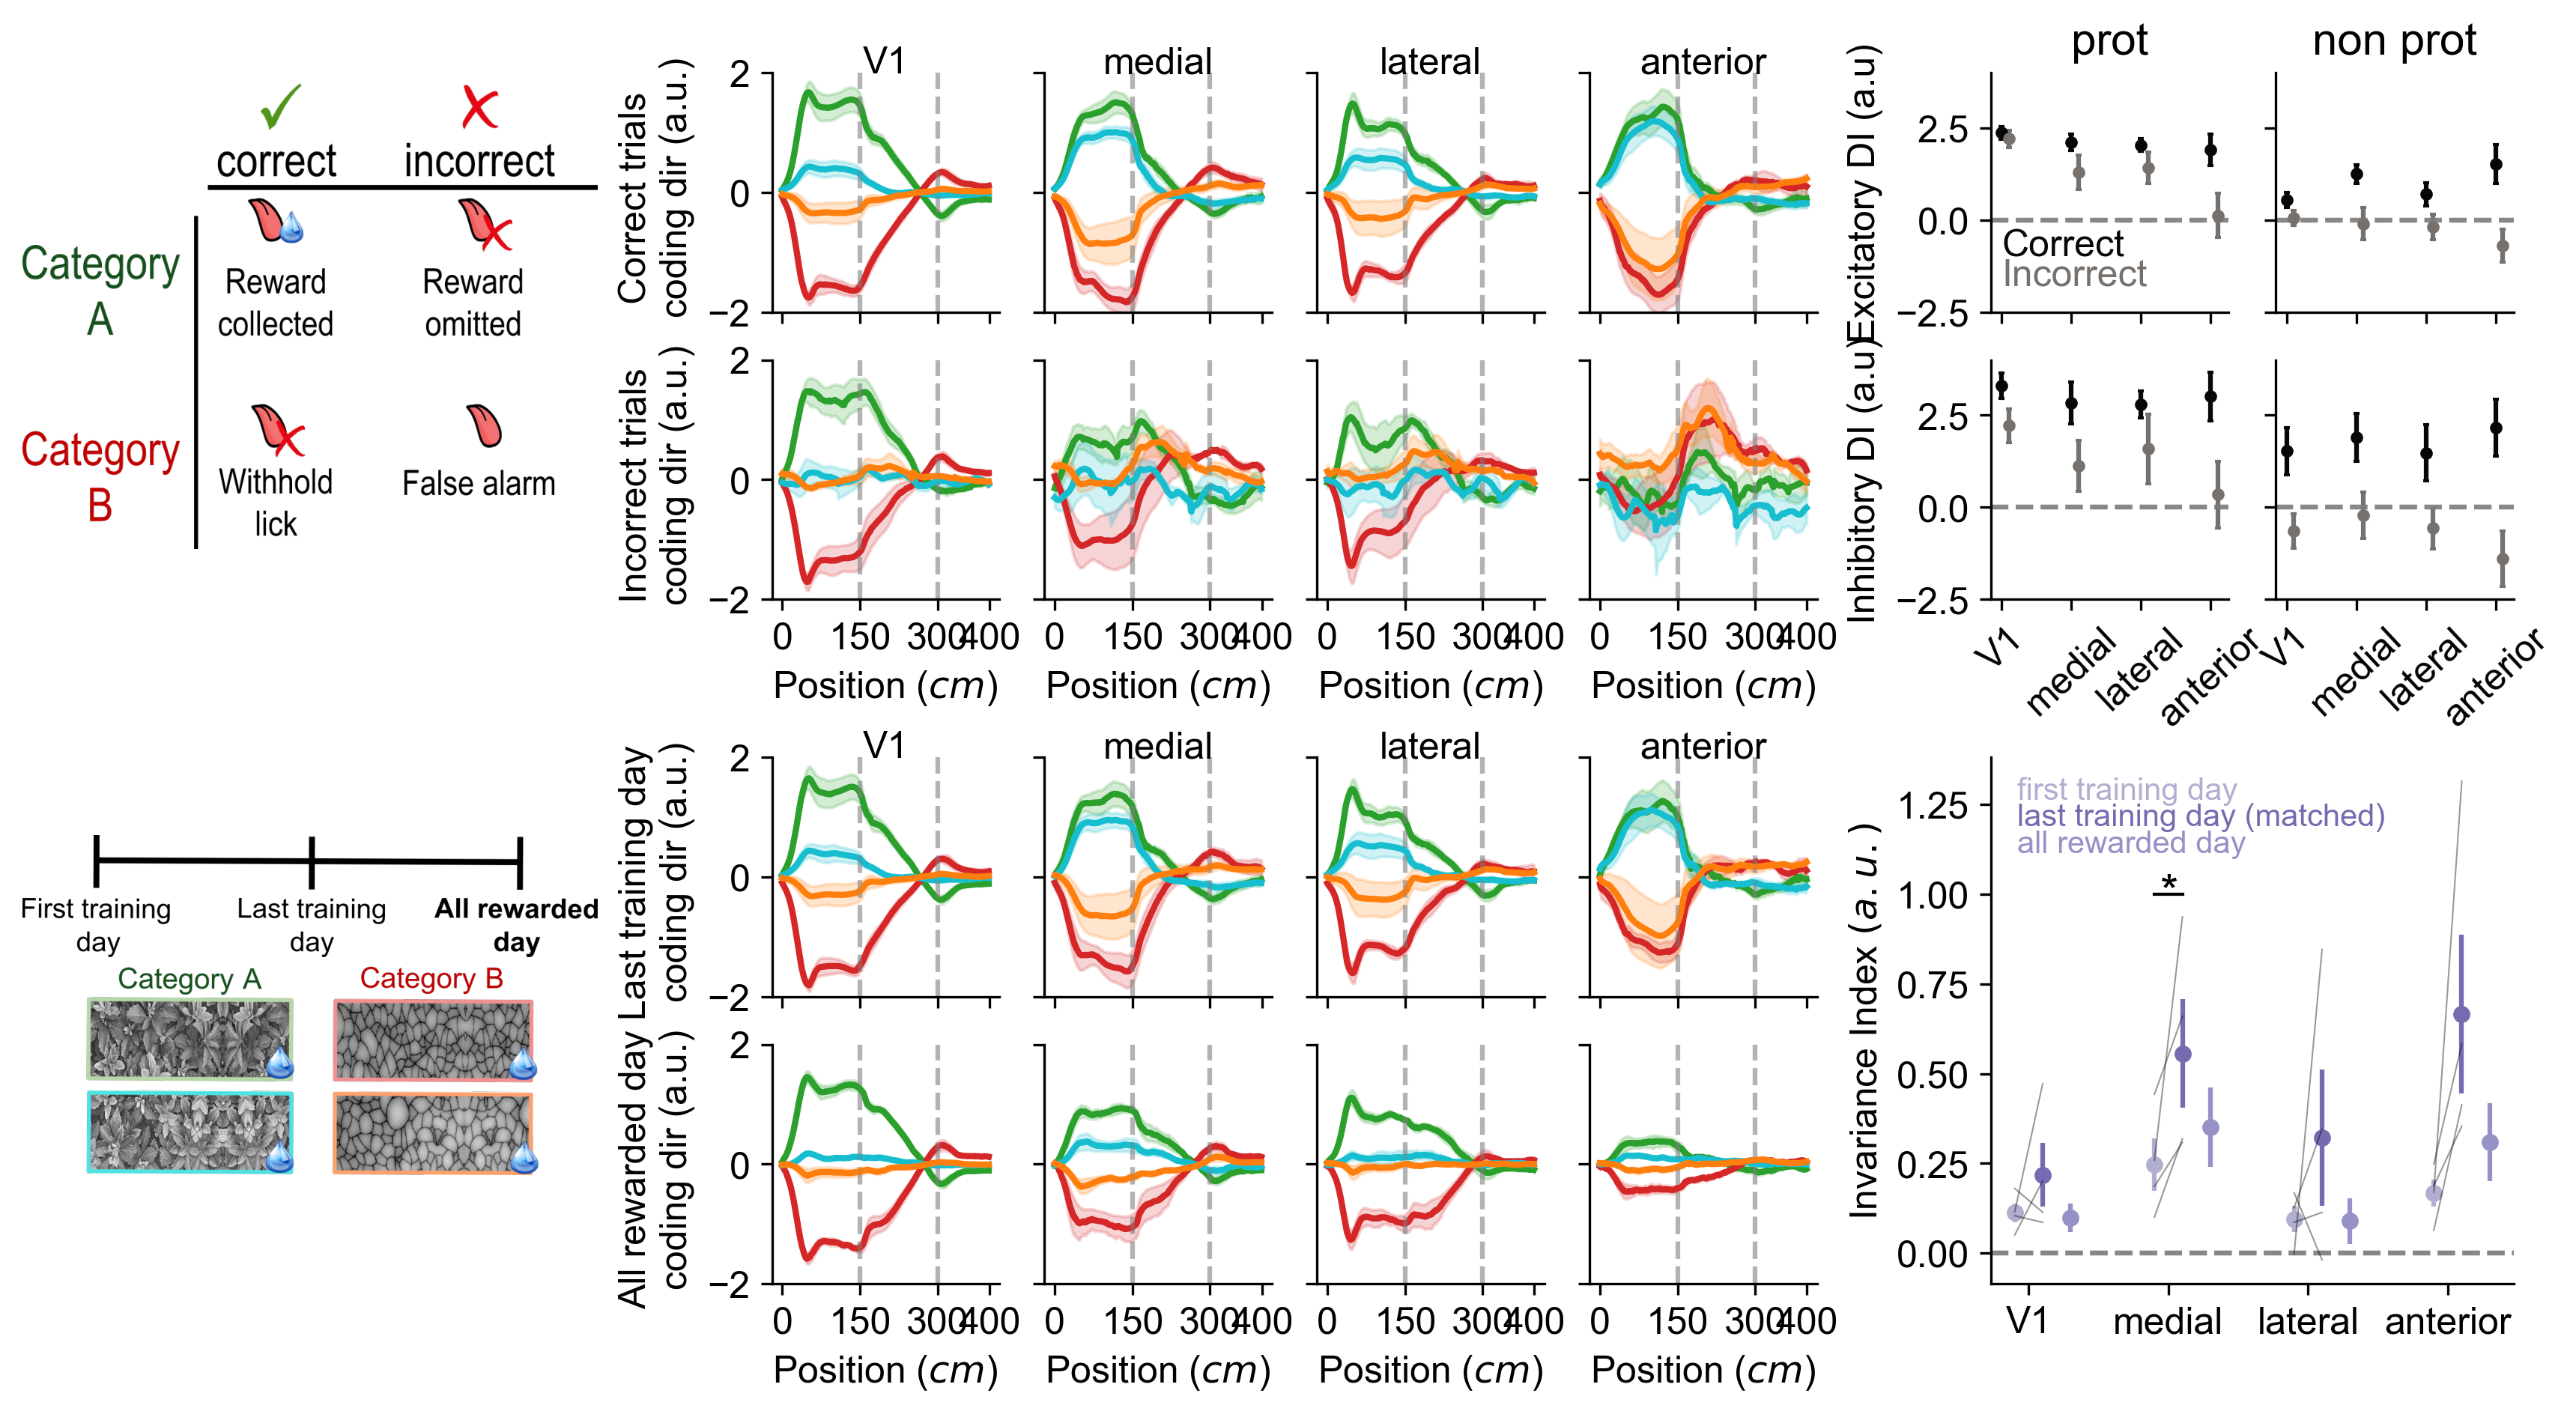

In [270]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
fig = plt.figure(figsize=(14, 7), dpi=300)
grid = GridSpec(2, 8, wspace=0.4, hspace=0.3, figure=fig)
row1  = GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[0,:], width_ratios=[.25,.5,.25], wspace=0.25)
row2  = GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[1,:], width_ratios=[.25,.5,.25], wspace=0.25)
c_i_grid = GridSpecFromSubplotSpec(2, 4, subplot_spec=row1[0,1])
c_i_axs = c_i_grid.subplots(sharex=True, sharey=True)
all_grid = GridSpecFromSubplotSpec(2, 4, subplot_spec=row2[0,1])
all_axs = all_grid.subplots(sharex=True, sharey=True)
img0 = fig.add_subplot(row1[0, 0])
di_grid = GridSpecFromSubplotSpec(2, 2, subplot_spec=row1[0,2])
di_axs = di_grid.subplots(sharex=True, sharey=True)
img1 = fig.add_subplot(row2[0, 0])
comp_ax = fig.add_subplot(row2[0, 2])


for iday, day_response in enumerate([correct, incorrect]):
    for a, area in enumerate(areas):
        c_i_axs[iday,a].set_ylim(-2,2)
        c_i_axs[0,a].tick_params(labelbottom=False)
        c_i_axs[0,a].set_title(f"{areas[a]}", loc='center', size=12, pad=-0.05)
        c_i_axs[1,a].set_xlabel("Position ($cm$)")
        if iday>0:
            c_i_axs[iday,a].set_xticks([0, 150, 300, 400])
        if a>0:
            c_i_axs[iday,a].tick_params(labelleft=False)
        for ttype in range(4):
            plot_cds(day_response, ttype, a, 0, c_i_axs[iday,a], references=True)
        
c_i_axs[0,0].set_ylabel('Correct trials \n coding dir (a.u.)')
c_i_axs[1,0].set_ylabel('Incorrect trials \n coding dir (a.u.)')


for iday, day_response in enumerate([last_day_matched_cds, all_rew_after_cds]):
    for a, area in enumerate(areas):
        all_axs[iday,a].set_ylim(-2,2)
        all_axs[0,a].tick_params(labelbottom=False)
        all_axs[0,a].set_title(f"{areas[a]}", loc='center', size=12, pad=-0.05)
        all_axs[1,a].set_xlabel("Position ($cm$)")
        if iday>0:
            all_axs[iday,a].set_xticks([0, 150, 300, 400])
        if a>0:
            all_axs[iday,a].tick_params(labelleft=False)
        for ttype in range(4):
            plot_cds(day_response, ttype, a, 0, all_axs[iday,a], references=True)
all_axs[0,0].set_ylabel('Last training day \n coding dir (a.u.)')
all_axs[1,0].set_ylabel('All rewarded day \n coding dir (a.u.)')

plot_gi_comparison_wcontrol2(gis_first, gis_last,  gis_allrew, comp_ax)




cell_types = ['Excitatory', 'Inhibitory']
positions = (0, 100)
labels = ['correct', 'incorrect']
from scipy.stats import sem
for ctype in range(2):
    for area in range(4):
        correct_sep_pr, incorrect_sep_pr = prot_di(correct, incorrect, area, ctype, pos=positions)
        prot_sep = (correct_sep_pr, incorrect_sep_pr)
        correct_sep_rest, incorrect_sep_rest = rest_di(correct, incorrect, area, ctype, pos=positions)
        test_sep = (correct_sep_rest, incorrect_sep_rest)
        for iff, eff in enumerate([prot_sep, test_sep]):
            c_eff = eff[0].mean()
            c_sem_eff = sem(eff[0])
            i_eff = eff[1].mean()
            i_sem_eff = sem(eff[1])
            di_axs[ctype, iff].errorbar(area, c_eff, yerr=c_sem_eff, fmt='o', capsize=1, markersize=3, color="#070707")
            di_axs[ctype, iff].errorbar(area+.1, i_eff, yerr=i_sem_eff, fmt='o', capsize=1, markersize=3, color= "#76716d")
            di_axs[ctype, iff].set_ylim(-2.5, 4)
            di_axs[0, iff].set_title(f"{['prot', 'non prot'][iff]}", loc='center')
            di_axs[1, iff].set_xticks(np.arange(4), ['V1', 'medial', 'lateral', 'anterior'], rotation=43)
            di_axs[ctype, iff].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            di_axs[ctype, 0].set_ylabel(f'{cell_types[ctype]} DI (a.u)')


            #axes[ctype].set_ylim(-.2, 1)
di_axs[0,0].text(0, -.7, 'Correct', ha='left', va='center', color="#070707")
di_axs[0,0].text(0, -1.5, 'Incorrect', ha='left', va='center', color="#76716d")

show_image(img0, r"C:\Users\labadmin\Pictures\ci.png")
move_axis(img0, hdx=-.05, vdx=0, widthdx=1.5, heightdx=1.1)

show_image(img1, r"C:\Users\labadmin\Pictures\allrew.png")
move_axis(img1, hdx=-.05, vdx=0, widthdx=1.5, heightdx=1.1)

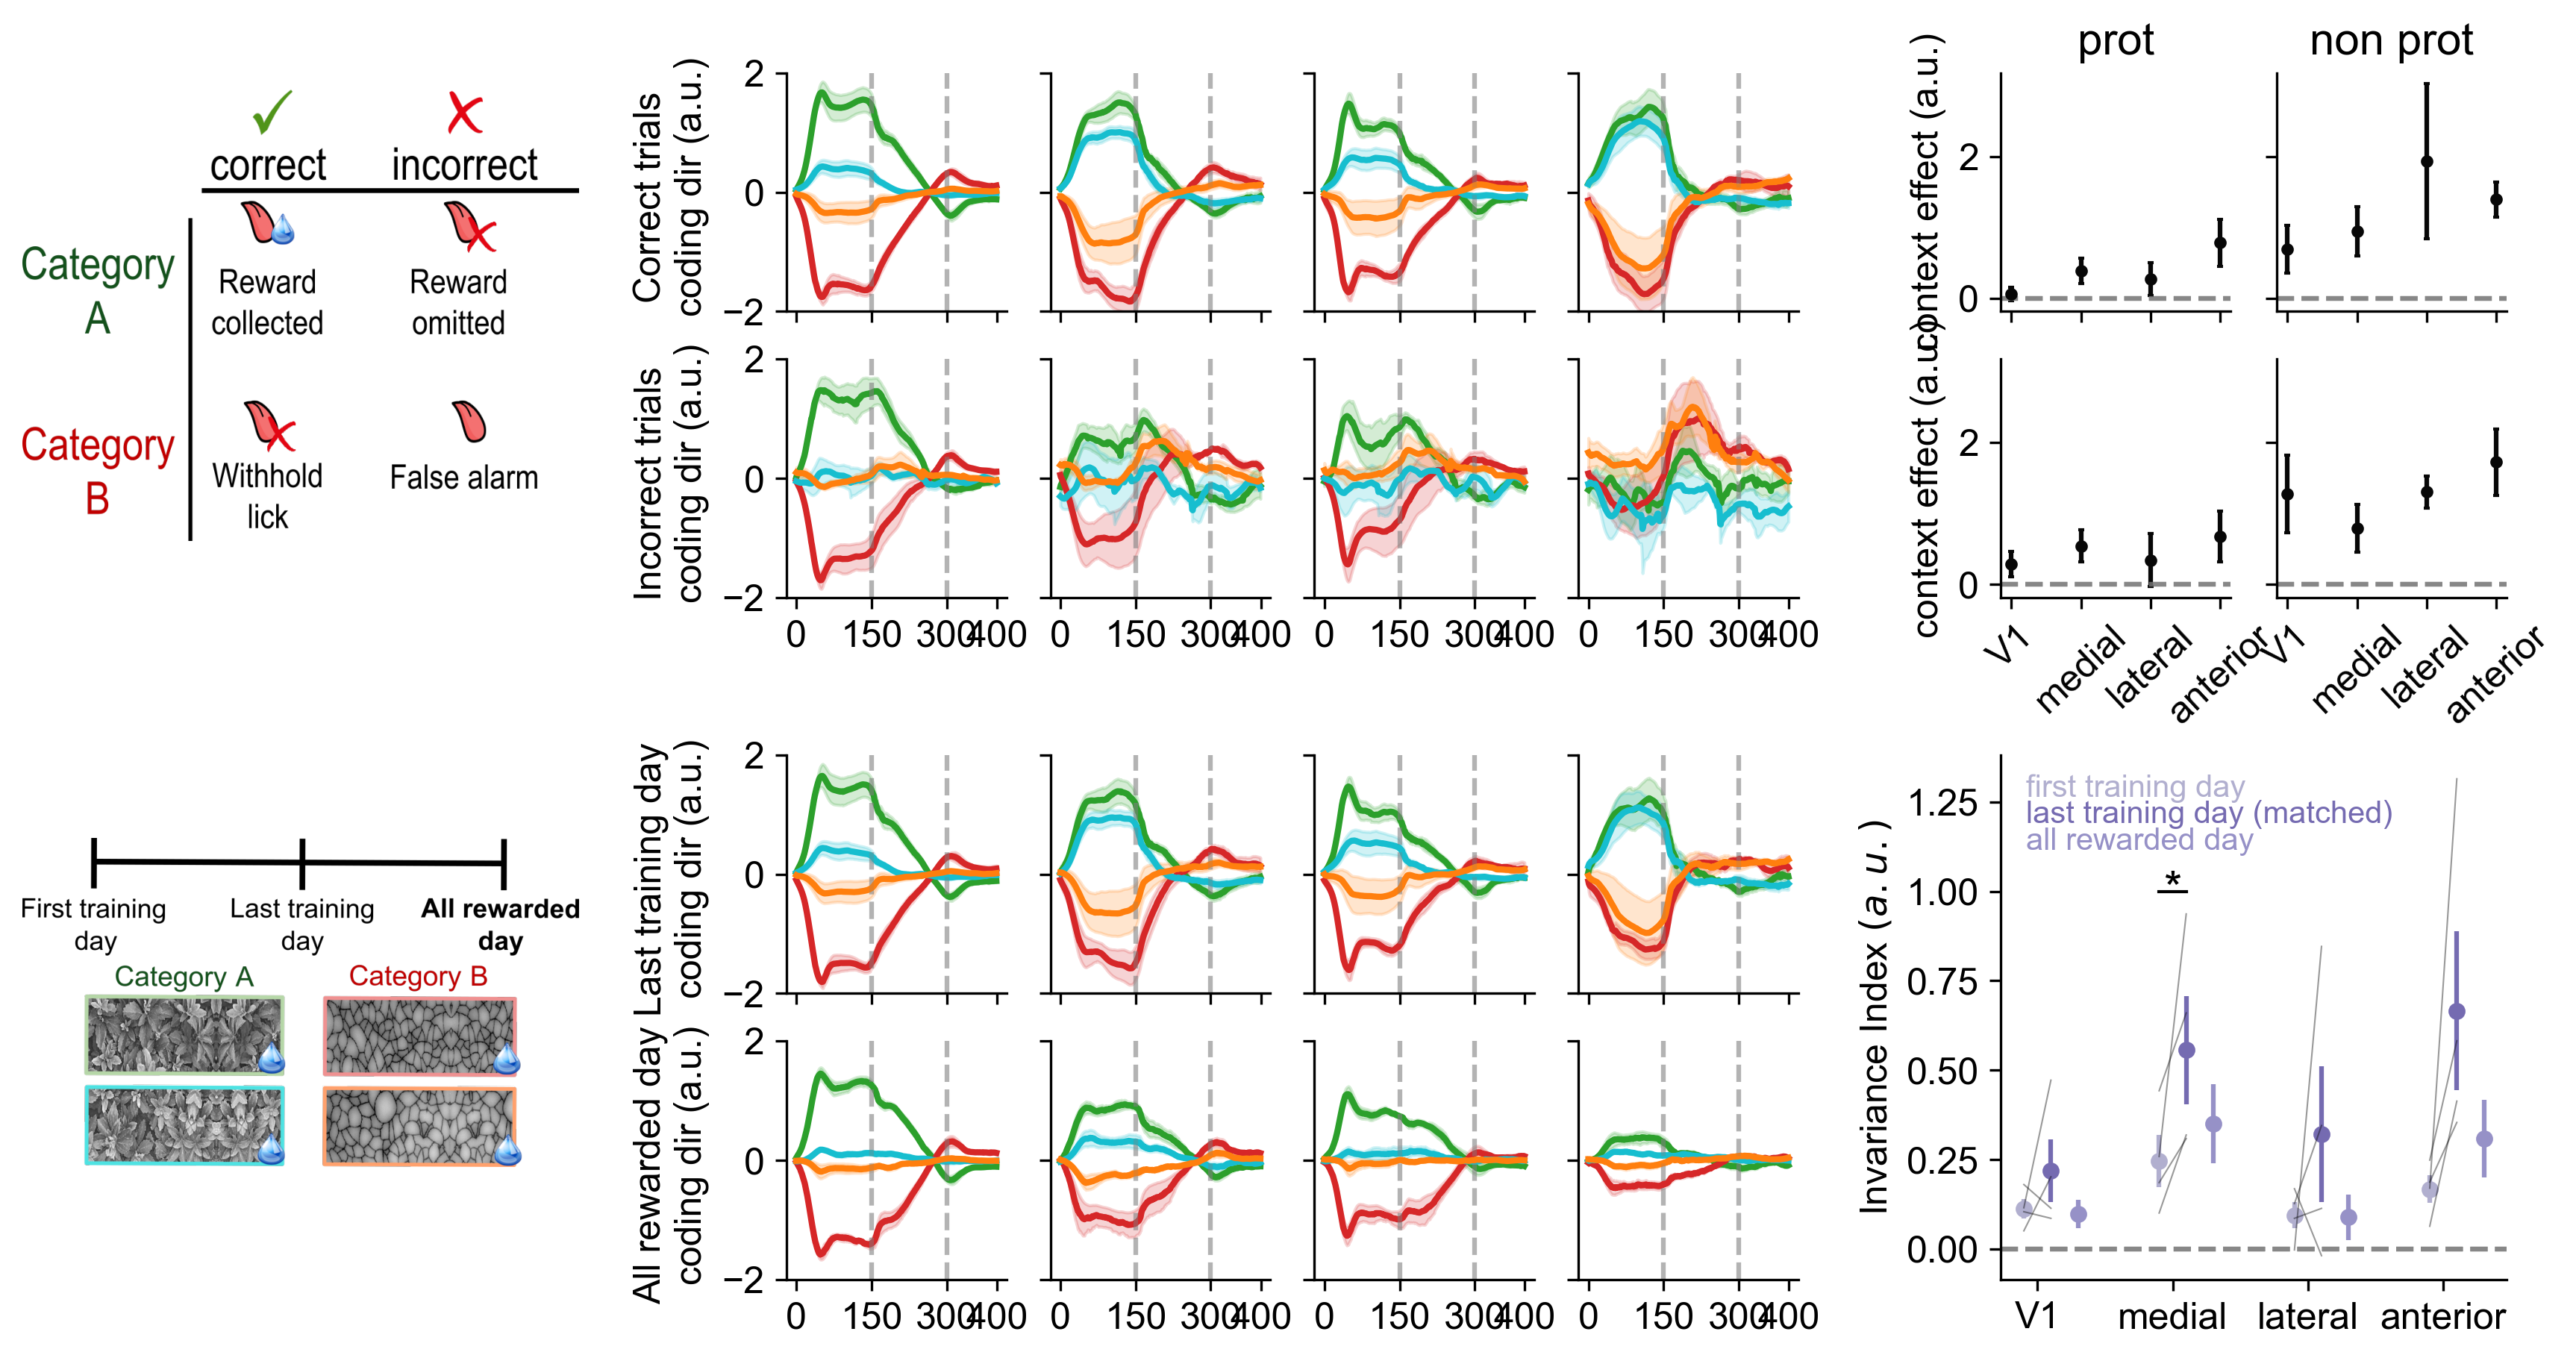

In [198]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
fig = plt.figure(figsize=(14, 7), dpi=300)
grid = GridSpec(2, 8, wspace=0.4, hspace=0.3, figure=fig)
row1  = GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[0,:], width_ratios=[.25,.5,.25], wspace=0.3)
row2  = GridSpecFromSubplotSpec(1, 3, subplot_spec=grid[1,:], width_ratios=[.25,.5,.25], wspace=0.3)
c_i_grid = GridSpecFromSubplotSpec(2, 4, subplot_spec=row1[0,1])
c_i_axs = c_i_grid.subplots(sharex=True, sharey=True)
all_grid = GridSpecFromSubplotSpec(2, 4, subplot_spec=row2[0,1])
all_axs = all_grid.subplots(sharex=True, sharey=True)
img0 = fig.add_subplot(row1[0, 0])
di_grid = GridSpecFromSubplotSpec(2, 2, subplot_spec=row1[0,2])
di_axs = di_grid.subplots(sharex=True, sharey=True)
img1 = fig.add_subplot(row2[0, 0])
comp_ax = fig.add_subplot(row2[0, 2])


for iday, day_response in enumerate([correct, incorrect]):
    for a, area in enumerate(areas):
        c_i_axs[iday,a].set_ylim(-2,2)
        c_i_axs[0,a].tick_params(labelbottom=False)
        if iday>0:
            c_i_axs[iday,a].set_xticks([0, 150, 300, 400])
        if a>0:
            c_i_axs[iday,a].tick_params(labelleft=False)
        for ttype in range(4):
            plot_cds(day_response, ttype, a, 0, c_i_axs[iday,a], references=True)
c_i_axs[0,0].set_ylabel('Correct trials \n coding dir (a.u.)')
c_i_axs[1,0].set_ylabel('Incorrect trials \n coding dir (a.u.)')


for iday, day_response in enumerate([last_day_matched_cds, all_rew_after_cds]):
    for a, area in enumerate(areas):
        all_axs[iday,a].set_ylim(-2,2)
        all_axs[0,a].tick_params(labelbottom=False)
        if iday>0:
            all_axs[iday,a].set_xticks([0, 150, 300, 400])
        if a>0:
            all_axs[iday,a].tick_params(labelleft=False)
        for ttype in range(4):
            plot_cds(day_response, ttype, a, 0, all_axs[iday,a], references=True)
all_axs[0,0].set_ylabel('Last training day \n coding dir (a.u.)')
all_axs[1,0].set_ylabel('All rewarded day \n coding dir (a.u.)')

plot_gi_comparison_wcontrol2(gis_first, gis_last,  gis_allrew, comp_ax)




cell_types = ['Excitatory', 'Inhibitory']
positions = (0, 100)
labels = ['correct', 'incorrect']
from scipy.stats import sem
for ctype in range(2):
    for area in range(4):
        correct_sep_pr, incorrect_sep_pr = prot_di(correct, incorrect, area, ctype, pos=positions)
        prot_sep = 1-(incorrect_sep_pr/correct_sep_pr+1e-10)
        correct_sep_rest, incorrect_sep_rest = rest_di(correct, incorrect, area, ctype, pos=positions)
        test_sep = 1-(incorrect_sep_rest/correct_sep_rest+1e-10)
        for iff, eff in enumerate([prot_sep, test_sep]):
            c_eff = eff.mean()
            c_sem_eff = sem(eff)
            di_axs[ctype, iff].errorbar(area, c_eff, yerr=c_sem_eff, fmt='o', capsize=1, markersize=3, color="#070707")
            #di_axs[ctype, iff].set_ylim(-2.5, 4)
            di_axs[0, iff].set_title(f"{['prot', 'non prot'][iff]}", loc='center')
            di_axs[1, iff].set_xticks(np.arange(4), ['V1', 'medial', 'lateral', 'anterior'], rotation=43)
            di_axs[ctype, iff].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            di_axs[ctype, 0].set_ylabel(f'context effect (a.u.)')


            #axes[ctype].set_ylim(-.2, 1)
#di_axs[0,0].text(0, -.7, 'Correct', ha='left', va='center', color="#070707")
#di_axs[0,0].text(0, -1.5, 'Incorrect', ha='left', va='center', color="#76716d")

show_image(img0, r"C:\Users\labadmin\Pictures\ci.png")
move_axis(img0, hdx=-.05, vdx=0, widthdx=1.5, heightdx=1.1)

show_image(img1, r"C:\Users\labadmin\Pictures\allrew.png")
move_axis(img1, hdx=-.05, vdx=0, widthdx=1.5, heightdx=1.1)

In [164]:
def get_ax_size(ax, pixels=False):
    """
    Get the size of the axes in inches.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes for which to get the size.
    Returns
    -------
    tuple
        The width and height of the axes in inches.
    """
    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    if pixels:
        width, height = bbox.width * ax.figure.dpi, bbox.height * ax.figure.dpi
    else:
        width, height = bbox.width, bbox.height
    return width, height

In [167]:
get_ax_size(img0)

(2.260416666666668, 2.343478260869565)